Dali code is from @tivfrvqhs5, see
https://www.kaggle.com/competitions/rsna-breast-cancer-detection/discussion/371534

How to use:
1. make a dictionary of { machine_id: TransferSyntaxUID } using the function make_transfer_syntax_uid()

2. in your dataloader, iterate over each patient id. For (each patient id, machine_id) pair, load all images using function read_image_with_dicomsdl() or read_image_with_dali(), according to dictionary TransferSyntaxUID[machine_id]

In [1]:
# todo
# ! pip download
! pip install --extra-index-url https://developer.download.nvidia.com/compute/redist/nightly --upgrade nvidia-dali-nightly-cuda110
! pip install dicomsdl
! pip install pylibjpeg
! pip install python-gdcm

print('install ok')

Looking in indexes: https://pypi.org/simple, https://developer.download.nvidia.com/compute/redist/nightly
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.5/446.5 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 334.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 10.9 MB/s eta 0:00:00
install ok


In [2]:
import dicomsdl
def __dataset__to_numpy_image(self, index=0):
    info = self.getPixelDataInfo()
    dtype = info['dtype']
    if info['SamplesPerPixel'] != 1:
        raise RuntimeError('SamplesPerPixel != 1')
    else:
        shape = [info['Rows'], info['Cols']]
    outarr = np.empty(shape, dtype=dtype)
    self.copyFrameData(index, outarr)
    return outarr
dicomsdl._dicomsdl.DataSet.to_numpy_image = __dataset__to_numpy_image


import nvidia.dali as dali
#https://github.com/NVIDIA/DALI/issues/2330
#https://medium.datadriveninvestor.com/gpu-accelerated-data-loading-with-dali-part-2-pipelines-and-data-loaders-99f51548e8a6
#https://github.com/NVIDIA/DALI/blob/main/dali/python/nvidia/dali/plugin/pytorch.py
#https://zhuanlan.zhihu.com/p/518240063

class ExternalInputIterator(object):
    def __init__(self,jpeg_stream):
        self.jpeg_stream = jpeg_stream
    def __iter__(self):
        return self
    def __next__(self):
        return self.jpeg_stream

@dali.pipeline_def
def j2k_decode_pipeline(eii, is_resize=False):
    jpeg  = dali.fn.external_source(source=eii, dtype=dali.types.UINT8)
    image = dali.fn.experimental.decoders.image(jpeg, device='mixed', output_type=dali.types.ANY_DATA, dtype=dali.types.UINT16)
    if is_resize:
        image = dali.fn.resize(image, size=[image_size, image_size])
    return image

##################################################################################
import pydicom
import pandas as pd
import numpy as np
import cv2


from timeit import default_timer as timer
#from tqdm.notebook import tqdm
from tqdm import tqdm
from joblib import Parallel, delayed
from glob import glob


def time_to_str(t, mode='min'):
    if mode=='min':
        t  = int(t)/60
        hr = t//60
        min = t%60
        return '%2d hr %02d min'%(hr,min)

    elif mode=='sec':
        t   = int(t)
        min = t//60
        sec = t%60
        return '%2d min %02d sec'%(min,sec)

    else:
        raise NotImplementedError


print('import ok!')

import ok!


In [3]:

image_size = 1024

mode = 'local-dicom'   #

if 'local' in mode:
    csv_file = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
    #csv_file  = '/home/titanx/hengck/share1/kaggle/2022/rsna-breast-mammography/data/valid_df.fold0.csv'
    dcm_dir   = '/kaggle/input/rsna-breast-cancer-detection/train_images'
 
if 'submit' in mode:
    csv_file = '/kaggle/input/rsna-breast-cancer-detection/test.csv'
    dcm_dir  = '/kaggle/input/rsna-breast-cancer-detection/test_images'


def make_transfer_syntax_uid(df):
    machine_id_to_transfer = {}
    machine_id = df.machine_id.unique()
    for i in machine_id:
        d = df[df.machine_id==i].iloc[0]
        f = f'{dcm_dir}/{d.patient_id}/{d.image_id}.dcm'
        dicom = pydicom.dcmread(f)
        machine_id_to_transfer[i]= dicom.file_meta.TransferSyntaxUID
    return machine_id_to_transfer
'''
1.2.840.10008.1.2.4.70 = JPEG Lossless, Nonhierarchical, First- Order Prediction (Processes 14)
1.2.840.10008.1.2.4.90 = JPEG 2000 Image Compression (Lossless Only)
'''


test_df = pd.read_csv(csv_file)
machine_id_to_transfer = make_transfer_syntax_uid(test_df)

test_df.loc[:, 'i'] = np.arange(len(test_df))
test_df.loc[:,'TransferSyntaxUID']=test_df.machine_id.map(machine_id_to_transfer)
if 'local' in mode:
    test_df.loc[:, 'prediction_id'] = test_df.patient_id.astype(str) + '_' + test_df.laterality
    if 'dicom' in mode:
        # if 1:
        test_id = [
            #  1.2.840.10008.1.2.4.70  count(14)
            65, 127, 152, 272, 282, 308, 477, 505, 2989, 3542, 7780, 9014, 11094, 11937,
            #  1.2.840.10008.1.2.4.90  count(26)
            30, 36, 90, 111, 122, 158, 204, 289, 299, 399, 425, 454, 826, 1703, 1759, 2346, 3021, 4340, 4824, 5059, 5769, 6654, 6658, 7053, 7493, 14292
        ]
        test_df = test_df[test_df.patient_id.isin(test_id)].reset_index(drop=True)
print(test_df.shape)
print(test_df)


### read dicom
def norm_data(m):
    max=m.max()
    min=m.min()
    m = (m-min)/(max-min+1e-6) #float32
    m = m.astype(np.float16)
    return m


def read_image_with_dicomsdl_non_parallel(df): 
    image = []
    for t,d in df.iterrows():
        dcm_file = f'{dcm_dir}/{d.patient_id}/{d.image_id}.dcm'
        dicom = dicomsdl.open(dcm_file)
        m = dicom.to_numpy_image()
        m = norm_data(m)
        if dicom.PhotometricInterpretation== 'MONOCHROME1':
            m = 1-m
        image.append(m)

    image = np.stack(image)
    return image


def parallel_process(f):
    dicom = dicomsdl.open(f)
    m = dicom.to_numpy_image()
    m = norm_data(m)
    if dicom.PhotometricInterpretation== 'MONOCHROME1':
        m = 1-m
    return m

def read_image_with_dicomsdl(df):

    #https://stackoverflow.com/questions/56659294/does-joblib-parallel-keep-the-original-order-of-data-passed
    image =  Parallel(n_jobs=2, backend='multiprocessing')(
        delayed(parallel_process)(f'{dcm_dir}/{d.patient_id}/{d.image_id}.dcm')
        for t,d in df.iterrows()
    )
    image = np.stack(image)
    return image




def read_image_with_dali(df):

    jpeg_stream = []
    invert = []
    for t,d in df.iterrows():
        dcm_file = f'{dcm_dir}/{d.patient_id}/{d.image_id}.dcm'
        dicom = pydicom.dcmread(dcm_file)
        s = dicom.PixelData
        offset = s.find(b'\x00\x00\x00\x0C')  # <---- the jpeg2000 header info we're looking for
        jpeg_stream.append(
            np.array(bytearray(s[offset:]), np.uint8)
        )
        invert.append(
            dicom.PhotometricInterpretation == 'MONOCHROME1'
        )

    pipe = j2k_decode_pipeline(ExternalInputIterator(jpeg_stream), batch_size=len(jpeg_stream), num_threads=2, device_id=0, debug=True)
    pipe.build()
    pipe_out = pipe.run()

    #todo : use feed_ndarray() /nvidia/dali/plugin/pytorch.py to directly convert to gpu pytorch tensor
    pipe_out = pipe_out[0].as_cpu().as_array().squeeze(-1)
    #print(pipe_out.shape)

    image = []
    for i in range(len(df)):
        m = pipe_out[i]
        m = norm_data(m)
        if invert[i]:
            m = 1-m
        image.append(m)

    image = np.stack(image)
    return image

(178, 17)
     site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0          1       11094  1086977375          L  MLO  74.0       1       1   
1          1       11094  1417771843          L   CC  74.0       1       1   
2          1       11094  1882170663          L   CC  74.0       1       1   
3          1       11094  1926447510          L   CC  74.0       1       1   
4          1       11094  1069719282          R   CC  74.0       0       0   
..       ...         ...         ...        ...  ...   ...     ...     ...   
173        2          90  2035421283          R  MLO  62.0       0       0   
174        1        9014   958727958          L  MLO  71.0       1       1   
175        1        9014  2058123035          L   CC  71.0       1       1   
176        1        9014  1127453534          R   CC  71.0       0       0   
177        1        9014  1299037172          R  MLO  71.0       0       0   

     invasive  BIRADS  implant density  machine_id  d

In [4]:

##debug function:
if 1: 
    test_df = test_df[test_df.TransferSyntaxUID == '1.2.840.10008.1.2.4.90'].reset_index(drop=True)
    patient_id = sorted(test_df.patient_id.unique())
    print('num_image', len(test_df))
    print('num_patient', len(patient_id))
    print('')

    start_timer = timer()
    image0 = []
    for i in patient_id:
        df = test_df[test_df.patient_id==i].reset_index(drop=True)
        image0.append(read_image_with_dicomsdl(df))
    print('read_image_with_dicomsdl',time_to_str(timer() - start_timer, 'sec'))
   

    start_timer = timer()
    image1 = []
    for i in patient_id:
        df = test_df[test_df.patient_id == i].reset_index(drop=True)
        image1.append(read_image_with_dali(df))
    print('read_image_with_dali', time_to_str(timer() - start_timer, 'sec'))
    print('')


num_image 109
num_patient 26

read_image_with_dicomsdl  1 min 36 sec
read_image_with_dali  0 min 31 sec



30 (4, 2776, 2082)
diff 0.0 0.0 0.0



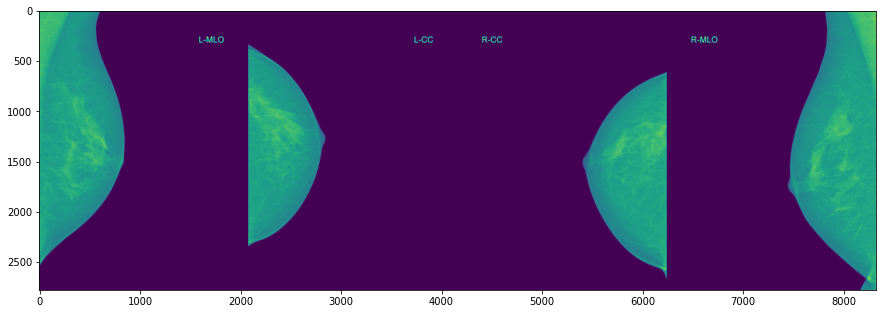

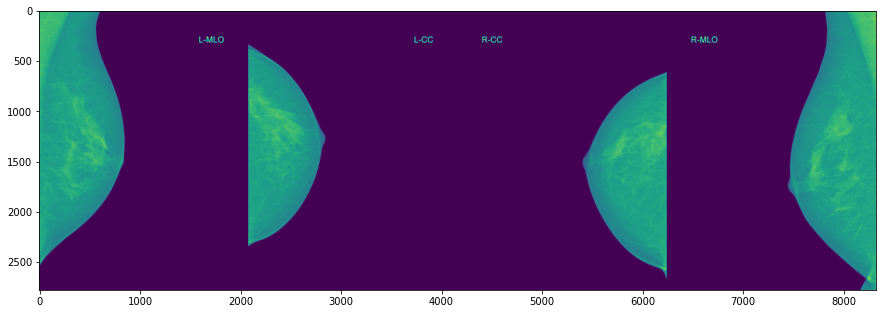

36 (5, 2776, 2082)
diff 0.0 0.0 0.0



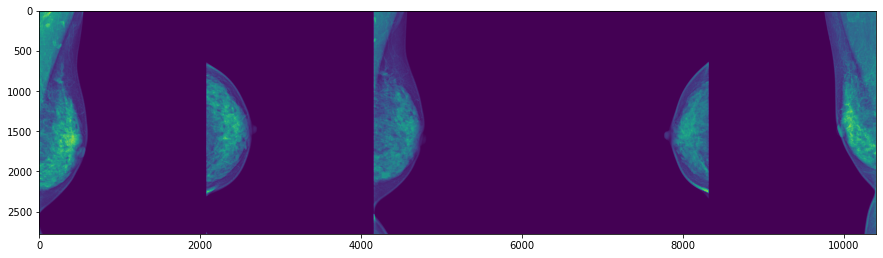

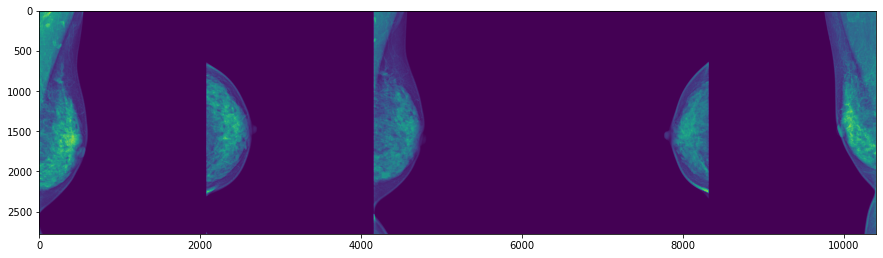

90 (4, 5355, 4915)
diff 0.0 0.0 0.0



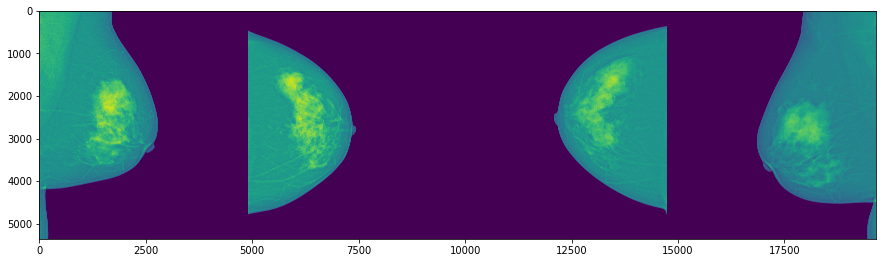

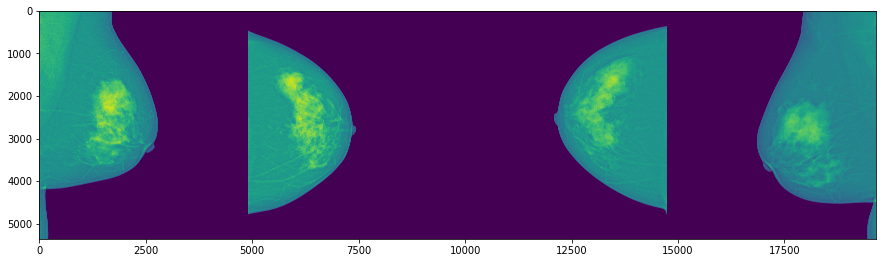

111 (4, 5355, 4915)
diff 0.0 0.0 0.0



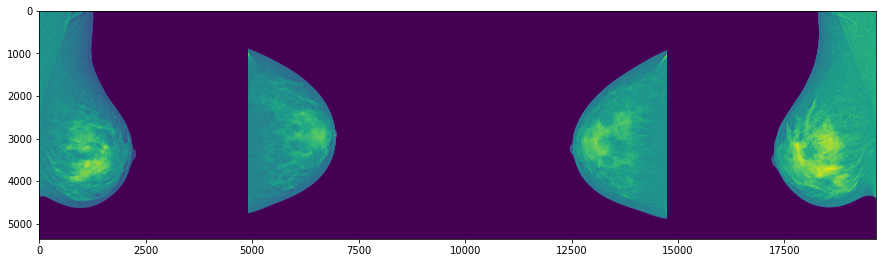

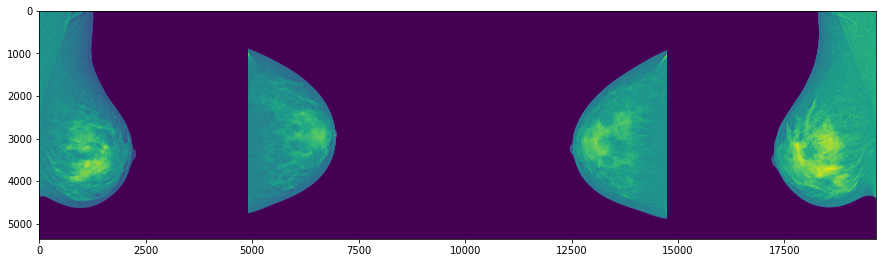

122 (4, 2776, 2082)
diff 0.0 0.0 0.0



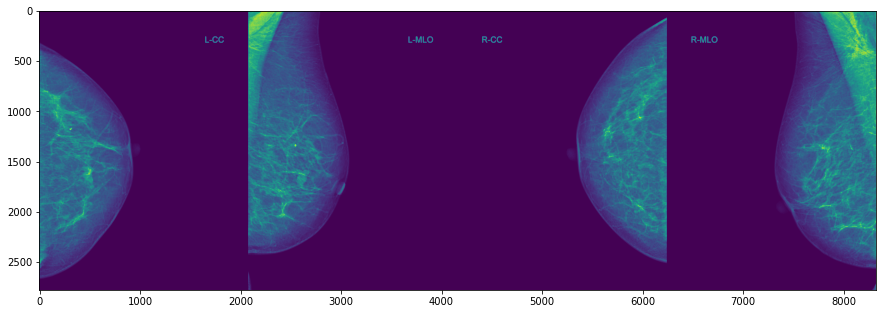

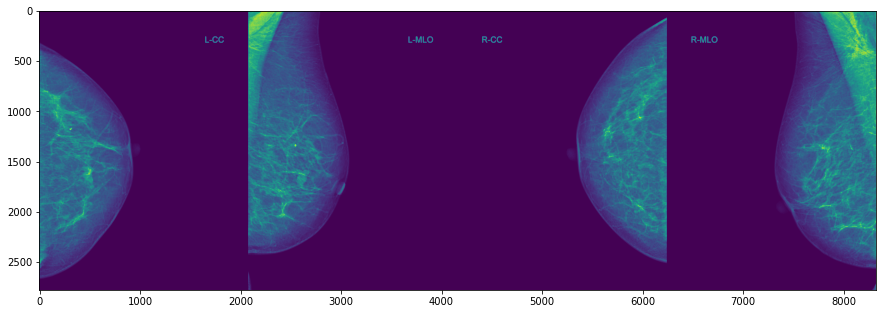

158 (4, 2776, 2082)
diff 0.0 0.0 0.0

204 (4, 4096, 3328)
diff 0.0 0.0 0.0

289 (4, 2776, 2082)
diff 0.0 0.0 0.0

299 (4, 2776, 2082)
diff 0.0 0.0 0.0

399 (4, 4096, 3328)
diff 0.0 0.0 0.0

425 (4, 4096, 3328)
diff 0.0 0.0 0.0

454 (4, 5355, 4915)
diff 0.0 0.0 0.0

826 (4, 4096, 3328)
diff 0.0 0.0 0.0

1703 (4, 4096, 3328)
diff 0.0 0.0 0.0

1759 (4, 5355, 4915)
diff 0.0 0.0 0.0

2346 (6, 4096, 3328)
diff 0.0 0.0 0.0

3021 (4, 2776, 2082)
diff 0.0 0.0 0.0

4340 (4, 4096, 3328)
diff 0.0 0.0 0.0

4824 (4, 4096, 3328)
diff 0.0 0.0 0.0

5059 (4, 2776, 2082)
diff 0.0 0.0 0.0

5769 (4, 4096, 3328)
diff 0.0 0.0 0.0

6654 (4, 4096, 3328)
diff 0.0 0.0 0.0

6658 (4, 2776, 2082)
diff 0.0 0.0 0.0

7053 (4, 2776, 2082)
diff 0.0 0.0 0.0

7493 (4, 2776, 2082)
diff 0.0 0.0 0.0

14292 (6, 2776, 2082)
diff 0.0 0.0 0.0



In [5]:
import matplotlib.pyplot as plt

#check difference
for b,i in enumerate(patient_id):

    m0 = image0[b]
    m1 = image1[b]

    #image = read_image_from_dicom_070(df)
    
    diff = m0.astype(np.float32) - m1.astype(np.float32)
    print(i, m0.shape)
    print('diff', diff.min(),diff.max(),diff.mean())
    print('')
    
    if b<=4:
        plt.figure(figsize=(15,20))
        plt.imshow(np.hstack([m for m in m0]))

        plt.figure(figsize=(15,20))
        plt.imshow(np.hstack([m for m in m1]))

        plt.show()

  